In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [38]:
"""
Title: Lasso and Ridge Regression Evaluation on Cryptocurrency Returns

Description:
This script performs a predictive evaluation of cryptocurrency log returns using 
Lasso and Ridge regression models. It trains the models on a specified historical 
window (`train_period_days`) and tests them on a future prediction horizon (`pred_period_days`), 
both configurable at the top of the script.

For each coin:
- Data is filtered and target returns are set as future log returns.
- Features are standardized using `StandardScaler`.
- Models (LassoCV and RidgeCV) are trained and evaluated.
- R² and MSE metrics are recorded for both models.
- A realized Sharpe ratio is computed using actual returns.
- A plot comparing true vs. predicted returns is saved for each coin.

The script outputs:
- A CSV (`lasso_ridge_results_[train]d_[test]d.csv`) summarizing performance metrics across coins.
- PNG plots for each coin stored in the `plots_lasso_ridge_[train]d_[test]d` folder.
- Log messages for any skipped or failed coins due to insufficient data or errors.

Make sure your data is stored in `datasets_2023-2025_1.parquet` and contains fields:
'timestamp', 'log_return', 'filename', and valid predictive features.

Example usage:
Set `train_period_days = 30` and `pred_period_days = 7` to train on 1 month and test on 1 week.
"""

train_period_days = 30         # Training period in days
pred_period_days = 7           # Prediction (test) period in days

# === Settings ===
data_path = "datasets_2023-2025_1.parquet"
plot_folder = f"plots_lasso_ridge_{train_period_days}d_{pred_period_days}d"
results_csv = f"lasso_ridge_results_{train_period_days}d_{pred_period_days}d.csv"

os.makedirs(plot_folder, exist_ok=True)

# === Load and prepare data ===
df = pd.read_parquet(data_path)
df = df.sort_values(["filename", "timestamp"])

# === Convert days to seconds ===
train_seconds = train_period_days * 24 * 60 * 60
pred_seconds = pred_period_days * 24 * 60 * 60

results = []

# === Group and evaluate each coin ===
for coin, coin_df in df.groupby("filename"):
    try:
        coin_df = coin_df.sort_values("timestamp")
        features = [col for col in coin_df.columns if col not in ['timestamp', 'return', 'log_return', 'filename']]
        coin_df = coin_df.dropna(subset=features + ['log_return'])
        coin_df['target'] = coin_df['log_return'].shift(-1)
        coin_df = coin_df.dropna()

        if len(coin_df) < 100:
            print(f"Skipping {coin}: not enough data.")
            continue

        start_ts = coin_df['timestamp'].min()
        train_end_ts = start_ts + train_seconds
        test_end_ts = train_end_ts + pred_seconds

        train_df = coin_df[(coin_df['timestamp'] >= start_ts) & (coin_df['timestamp'] < train_end_ts)]
        test_df = coin_df[(coin_df['timestamp'] >= train_end_ts) & (coin_df['timestamp'] < test_end_ts)]

        if len(train_df) < 50 or len(test_df) < 10:
            print(f"Skipping {coin}: not enough train/test data.")
            continue

        X_train = train_df[features]
        y_train = train_df['target']
        X_test = test_df[features]
        y_test = test_df['target']
        timestamps_test = test_df['timestamp']

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Models
        lasso = LassoCV(cv=3, max_iter=400000).fit(X_train_scaled, y_train)
        ridge = RidgeCV(cv=3).fit(X_train_scaled, y_train)

        y_pred_lasso = lasso.predict(X_test_scaled)
        y_pred_ridge = ridge.predict(X_test_scaled)

        # Metrics
        r2_lasso = r2_score(y_test, y_pred_lasso)
        r2_ridge = r2_score(y_test, y_pred_ridge)
        mse_lasso = mean_squared_error(y_test, y_pred_lasso)
        mse_ridge = mean_squared_error(y_test, y_pred_ridge)

        results.append({
            "coin": coin,
            "r2_lasso": r2_lasso,
            "r2_ridge": r2_ridge,
            "mse_lasso": mse_lasso,
            "mse_ridge": mse_ridge,
            "mean_actual_return": y_test.mean(),
            "std_actual_return": y_test.std(),
            "realized_sharpe": y_test.mean() / y_test.std() if y_test.std() > 0 else np.nan
        })

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(y_test.values, label="True", alpha=0.6)
        plt.plot(y_pred_lasso, label="Lasso", alpha=0.8)
        plt.plot(y_pred_ridge, label="Ridge", alpha=0.8)
        plt.title(f"{coin}: {train_period_days}d Train → {pred_period_days}d Test")
        plt.xlabel("Time Index")
        plt.ylabel("Log Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{plot_folder}/{coin}_prediction.png")
        plt.close()

    except Exception as e:
        print(f"Error with {coin}: {e}")
        continue

# === Save results ===
results_df = pd.DataFrame(results)
results_df.to_csv(results_csv, index=False)
print(f"\nProcessed {len(results_df)} coins and saved results to {results_csv}")


Processed 104 coins and saved results to lasso_ridge_results_30d_7d.csv


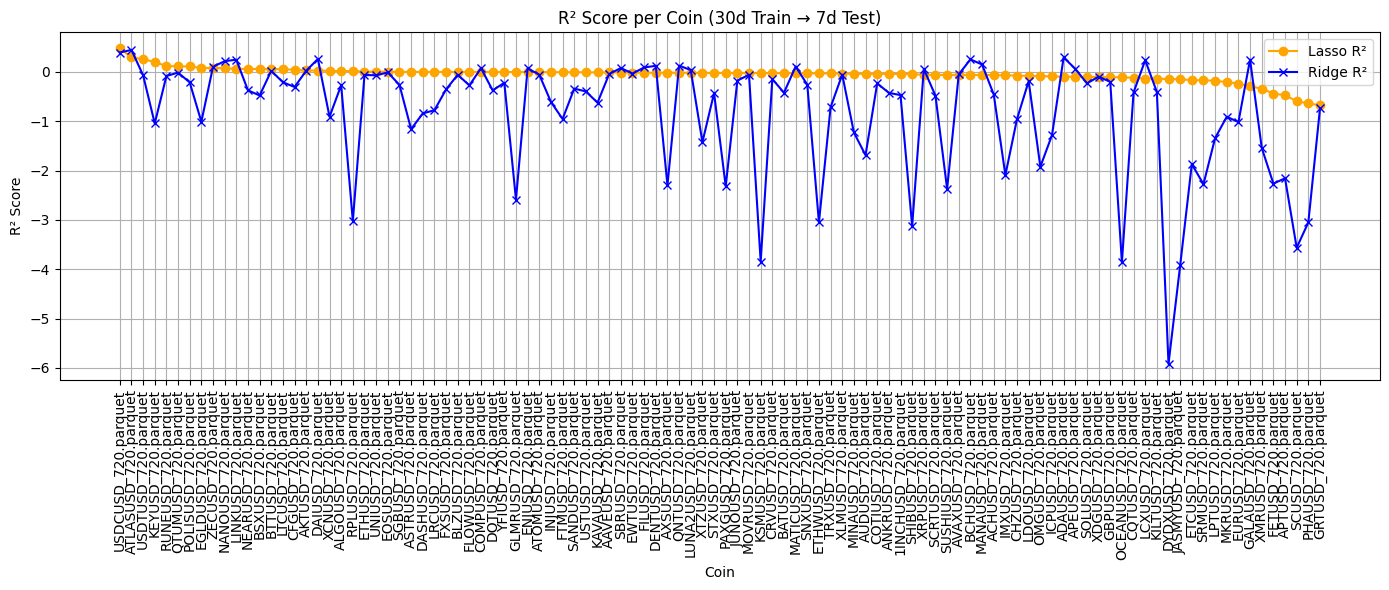

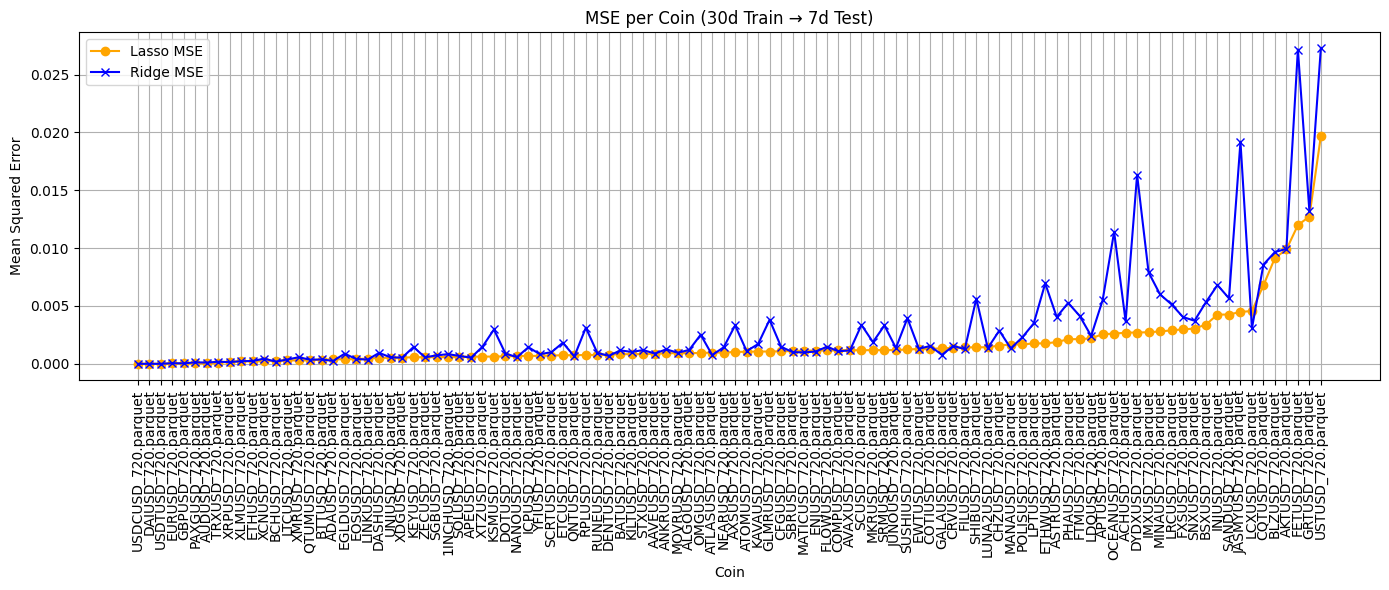

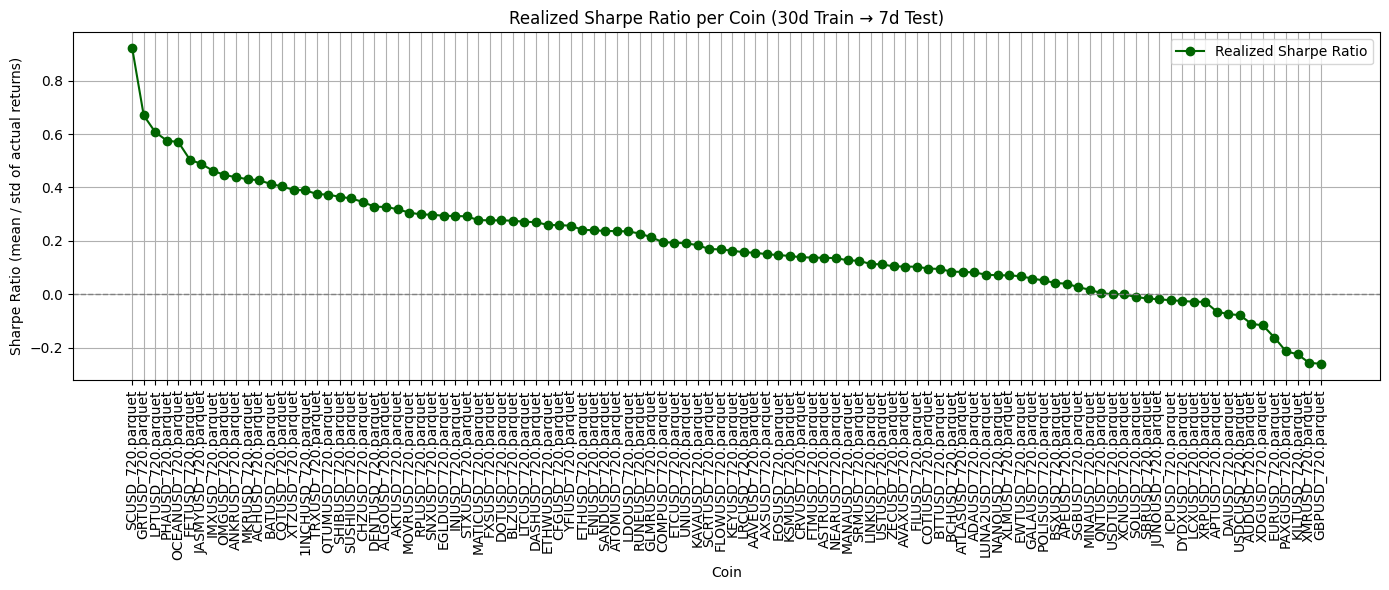

In [43]:
"""
Title: Visual Summary of Lasso and Ridge Performance Across Coins

Description:
This script generates diagnostic plots to evaluate and compare the performance of 
Lasso and Ridge regression models across multiple cryptocurrency assets.

Using results from the file `lasso_ridge_results_[train]d_[test]d.csv`, it produces:

1. R² Score Plot:
   - Visualizes the R² values for both Lasso and Ridge models, sorted by Lasso R².
   - Helps assess model fit quality per coin.

2. MSE Plot:
   - Compares Mean Squared Errors of Lasso and Ridge for each coin.
   - Coins are sorted by Lasso MSE for clarity.

3. Sharpe Ratio Plot:
   - Plots realized Sharpe ratios (mean / std of actual test returns).
   - Useful to evaluate risk-adjusted return potential by coin.
   - Includes a horizontal line at Sharpe = 0 to distinguish profitable vs. unprofitable coins.

All plots are labeled by coin and annotated with the training and test window durations
(`train_period_days` → `pred_period_days`), making this visualization easily reusable
across different time horizon configurations.

Make sure `results_csv` and the associated `train_period_days` and `pred_period_days` 
variables are set correctly before running this script.
"""

# === Plot Lasso and Ridge R² vs. Coins ===
df = pd.read_csv(f"{results_csv}")
df = df.sort_values("r2_lasso", ascending=False)

plt.figure(figsize=(14, 6))
plt.plot(df['coin'], df['r2_lasso'], label="Lasso R²", marker='o', color='orange')
plt.plot(df['coin'], df['r2_ridge'], label="Ridge R²", marker='x', color='blue')
plt.title(f"R² Score per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot MSE per Coin ===
df = df.sort_values("mse_lasso")

plt.figure(figsize=(14, 6))
plt.plot(df['coin'], df['mse_lasso'], label="Lasso MSE", marker='o', color='orange')
plt.plot(df['coin'], df['mse_ridge'], label="Ridge MSE", marker='x', color='blue')
plt.title(f"MSE per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Sharpe Ratio per Coin ===
df = df.sort_values("realized_sharpe", ascending=False)

plt.figure(figsize=(14, 6))
plt.plot(df['coin'], df['realized_sharpe'], label="Realized Sharpe Ratio", marker='o', color='darkgreen')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title(f"Realized Sharpe Ratio per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("Sharpe Ratio (mean / std of actual returns)")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
"""
Title: Filter Coins by Sharpe Threshold and Identify Outliers

Description:
This script filters cryptocurrency coins based on their realized Sharpe ratio 
using results from the Lasso/Ridge model evaluation (`results_csv`). It also 
flags statistical outliers in model performance metrics.

Key steps:
1. **Sharpe Ratio Filter**:
   - Coins with a realized Sharpe ratio below a user-defined threshold 
     (default = 2.0) are retained.
   - These represent assets with moderate or more realistic risk-adjusted return profiles.

2. **Outlier Detection**:
   - Flags coins with:
     - R² < -1 for Lasso or Ridge
     - MSE > 0.01 for Lasso or Ridge
   - These coins may indicate problematic model fits or noisy price series.

3. **Export**:
   - Saves the filtered set of coins to a CSV file dynamically named 
     `filtered_sharpe_coins_realistic_[train]d_[test]d.csv`, making it easy to reuse 
     in downstream strategy or model evaluation steps.

This script ensures that subsequent modeling or portfolio construction is based 
on cleaner, higher-quality signals.

Make sure `results_csv`, `train_period_days`, and `pred_period_days` are set properly.

"""

# === Sharpe Threshold Evaluation ===
metrics_df = pd.read_csv(results_csv)

# Threshold for filtering
threshold = 2.0
filtered_df = metrics_df[metrics_df["realized_sharpe"] < threshold]

# === Identify Outliers ===
outliers = metrics_df[
    (metrics_df["r2_lasso"] < -1) | 
    (metrics_df["r2_ridge"] < -1) |
    (metrics_df["mse_lasso"] > 0.01) | 
    (metrics_df["mse_ridge"] > 0.01)
]["coin"].tolist()

# Save filtered results using dynamic file naming
filtered_csv = f"filtered_sharpe_coins_realistic_{train_period_days}d_{pred_period_days}d.csv"
filtered_df.to_csv(filtered_csv, index=False)

# Print Summary
print(f"Saved filtered results to {filtered_csv}")
print(f"{len(filtered_df)} coins passed the Sharpe threshold (< {threshold})")
print(f"{len(metrics_df) - len(filtered_df)} coins failed the Sharpe threshold")
print(f"\nOutliers based on extreme R² or MSE values:\n{outliers}")

Saved filtered results to filtered_sharpe_coins_realistic_30d_7d.csv
104 coins passed the Sharpe threshold (< 2.0)
0 coins failed the Sharpe threshold

Outliers based on extreme R² or MSE values:
['APTUSD_720.parquet', 'ASTRUSD_720.parquet', 'AUDUSD_720.parquet', 'AXSUSD_720.parquet', 'DYDXUSD_720.parquet', 'EGLDUSD_720.parquet', 'ETCUSD_720.parquet', 'ETHWUSD_720.parquet', 'EURUSD_720.parquet', 'FETUSD_720.parquet', 'GLMRUSD_720.parquet', 'GRTUSD_720.parquet', 'ICPUSD_720.parquet', 'IMXUSD_720.parquet', 'JASMYUSD_720.parquet', 'KEYUSD_720.parquet', 'KSMUSD_720.parquet', 'LPTUSD_720.parquet', 'MINAUSD_720.parquet', 'OCEANUSD_720.parquet', 'OMGUSD_720.parquet', 'PAXGUSD_720.parquet', 'PHAUSD_720.parquet', 'RPLUSD_720.parquet', 'SCUSD_720.parquet', 'SHIBUSD_720.parquet', 'SRMUSD_720.parquet', 'SUSHIUSD_720.parquet', 'USTUSD_720.parquet', 'XMRUSD_720.parquet', 'XTZUSD_720.parquet']


In [ ]:
"""
Title: Long-Short Strategy Backtest Using Filtered Coins and Lasso Predictions

Description:
This script implements a simple long-short portfolio strategy using a filtered set 
of coins (based on Sharpe and model quality) and LassoCV-based return predictions.

Core workflow:
1. **Configurable Parameters**:
   - `train_period_days`: number of days used for model training.
   - `pred_period_days`: number of days for out-of-sample prediction.
   - `lookahead`: how many periods ahead the model is predicting.

2. **Data Preparation**:
   - Loads price/feature data and selects only coins that passed the Sharpe filter.
   - For each coin, splits its time series into training and test windows, scales the data,
     and trains a Lasso model to predict future log returns.

3. **Portfolio Construction**:
   - For each test timestamp, identifies the top 10% and bottom 10% of coins based on predicted return.
   - Computes the mean realized return of long (top) vs. short (bottom) selections.
   - Constructs a synthetic long-short portfolio and tracks cumulative returns.

4. **Evaluation**:
   - Plots cumulative returns over time.
   - Computes the annualized Sharpe ratio assuming hourly observations.

The script is fully dynamic and adjusts file paths, model scope, and strategy periods 
based on the `train_period_days` and `pred_period_days` values defined above.

This forms the final stage of a realistic, model-driven strategy pipeline for crypto return forecasting.
"""

# === Configurable Parameters ===
lookahead = 1
filtered_path = f"filtered_sharpe_coins_realistic_{train_period_days}d_{pred_period_days}d.csv"

# === Load data ===
df_full = pd.read_parquet(data_path).sort_values("timestamp")
filtered_coins = set(pd.read_csv(filtered_path)["coin"])
all_preds = []

# === Generate predictions ===
for coin in filtered_coins:
    coin_df = df_full[df_full["filename"].str.contains(coin)].copy()
    coin_df = coin_df.sort_values("timestamp")
    features = [col for col in coin_df.columns if col not in ['timestamp', 'return', 'log_return', 'filename']]
    coin_df = coin_df.dropna(subset=features + ['log_return'])
    coin_df['target'] = coin_df['log_return'].shift(-lookahead)
    coin_df = coin_df.dropna()

    if len(coin_df) < 100:
        continue

    # Dynamic train/test split
    start_ts = coin_df['timestamp'].min()
    train_end_ts = start_ts + train_period_days * 24 * 60 * 60
    test_end_ts = train_end_ts + pred_period_days * 24 * 60 * 60

    train_df = coin_df[(coin_df['timestamp'] >= start_ts) & (coin_df['timestamp'] < train_end_ts)]
    test_df = coin_df[(coin_df['timestamp'] >= train_end_ts) & (coin_df['timestamp'] < test_end_ts)]

    if len(train_df) < 50 or len(test_df) < 10:
        continue

    # Prepare data
    X_train = train_df[features]
    y_train = train_df['target']
    X_test = test_df[features]
    y_test = test_df['target']
    ts_test = test_df['timestamp']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LassoCV(cv=3, max_iter=400000).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    preds_df = pd.DataFrame({
        'timestamp': ts_test.values,
        'coin': coin,
        'actual_return': y_test.values,
        'predicted_return': y_pred
    })

    all_preds.append(preds_df)

# === Combine predictions ===
df_all = pd.concat(all_preds).sort_values("timestamp").dropna()
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"], unit="s")

# === Long-short portfolio strategy ===
portfolio_returns = []
top_decile = 0.1
bottom_decile = 0.1

for ts, group in df_all.groupby("timestamp"):
    group_sorted = group.sort_values("predicted_return", ascending=False)
    n = len(group_sorted)
    if n < 10:
        continue

    top_n = int(n * top_decile)
    bottom_n = int(n * bottom_decile)

    long_mean = group_sorted.iloc[:top_n]["actual_return"].mean()
    short_mean = group_sorted.iloc[-bottom_n:]["actual_return"].mean()
    long_short_return = long_mean - short_mean

    portfolio_returns.append({"timestamp": ts, "long_short_return": long_short_return})

df_portfolio = pd.DataFrame(portfolio_returns).sort_values("timestamp")
df_portfolio['cumulative_return'] = df_portfolio['long_short_return'].cumsum()

# === Plot results ===
plt.figure(figsize=(12, 5))
plt.plot(df_portfolio['timestamp'], df_portfolio['cumulative_return'], label="Long-Short Portfolio", color='orange')
plt.title(f"Cumulative Return (Filtered Coins, {train_period_days}d → {pred_period_days}d)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Compute Sharpe Ratio ===
def compute_sharpe(df, annualization_factor=8760):  # hourly
    r = df['long_short_return']
    return (r.mean() / r.std()) * np.sqrt(annualization_factor)

sharpe = compute_sharpe(df_portfolio)
print(f"\nEstimated Sharpe Ratio (Annualized Hourly): {sharpe:.2f}")